In [2]:
import glob
import random

from keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
washington_data = pd.DataFrame([file for file in glob.iglob("../data/**/*.jpg", recursive=True)])
washington_data = pd.DataFrame(washington_data[0])
washington_data['image_data'] = washington_data[0].apply(lambda x : np.asarray(Image.open(x)))
washington_data[[0, 1, 'name', 'image_id']] = washington_data[0].str.split("\\", expand = True)

In [4]:
washington_data_cleaned = washington_data[['name', 'image_id', 'image_data']]

In [22]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(pd.DataFrame(washington_data_cleaned['name']))

labels_onehot = encoder.transform(pd.DataFrame(washington_data_cleaned['name'])).toarray()

In [46]:
washington_images_stack = np.stack(washington_data_cleaned['image_data'], axis=0)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(washington_images_stack, labels_onehot, test_size=0.2)

In [148]:
num_classes = len(washington_data_cleaned['name'].unique())
dropout_rate = 0.3
img_dimension = (224, 224, 3)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

# takes input data, augments, and preps it for EfficientNetB0
inputs = layers.Input(shape=img_dimension)
x = data_augmentation(inputs) 
x = preprocess_input(x)

# preps EfficientNetB0 model (with its weights) to train with our model
base_model = EfficientNetB0(include_top=False, input_tensor=None, weights='imagenet')
base_model.trainable = False

# layers to train the model with our data
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [149]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
auc_metric = tf.keras.metrics.AUC(multi_label=True)
top_five_accuracy_metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)

EPOCHS = 10
BATCH_SIZE = 64

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', auc_metric, top_five_accuracy_metric])

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data = (X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.1149 - auc_13: 0.4973 - loss: 5.3661 - top_k_categorical_accuracy: 0.2110 - val_accuracy: 0.4508 - val_auc_13: 0.6789 - val_loss: 3.8867 - val_top_k_categorical_accuracy: 0.6865
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 57s 988ms/step - accuracy: 0.4834 - auc_13: 0.7661 - loss: 2.3264 - top_k_categorical_accuracy: 0.7328 - val_accuracy: 0.5795 - val_auc_13: 0.7406 - val_loss: 2.8099 - val_top_k_categorical_accuracy: 0.8000
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 56s 971ms/step - accuracy: 0.6426 - auc_13: 0.8274 - loss: 1.4726 - top_k_categorical_accuracy: 0.8741 - val_accuracy: 0.6735 - val_auc_13: 0.7573 - val_loss: 2.0310 - val_top_k_categorical_accuracy: 0.8605
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 55s 944ms/step - accuracy: 0.7400 - auc_13: 0.8511 - loss: 1.0582 - top_k_categorical_accuracy: 0.9245 - val_accuracy: 0.7157 - val_auc_13: 0.7632 - val_loss: 1.5685 - val_top_k_categorical_accuracy: 0.8789
Epoch 5/10
58/58 ━━━━━━

In [150]:
model.save('224x224 image classification EfficientNetB0.keras')

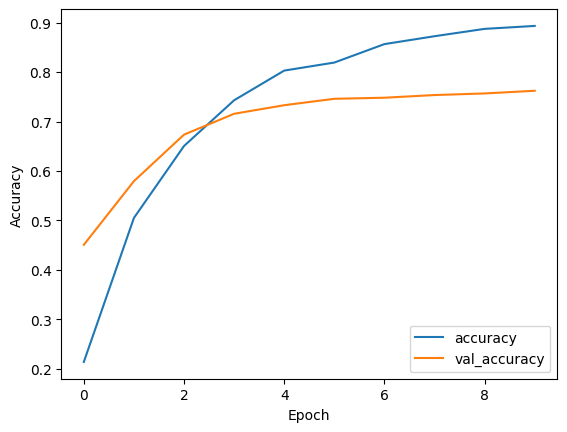

In [151]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

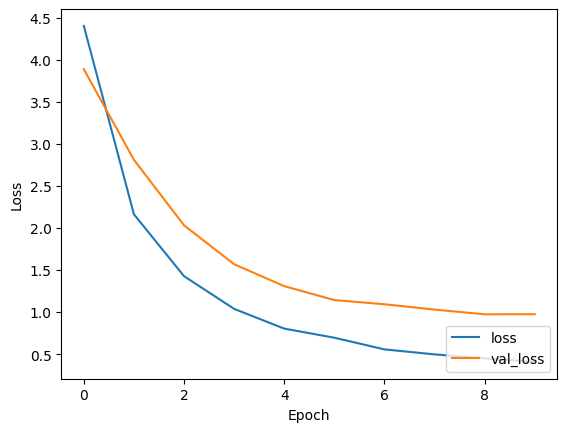

In [152]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

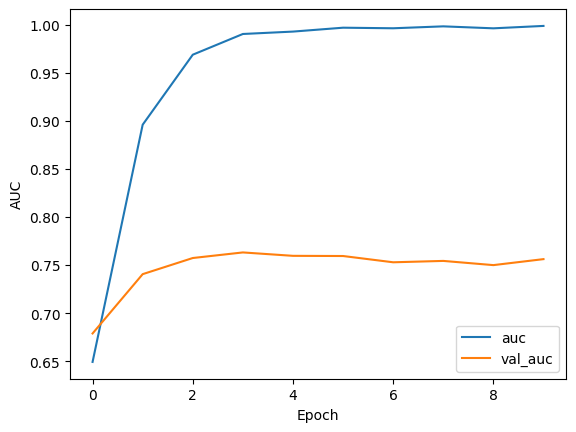

In [154]:
plt.plot(history.history['auc_13'], label='auc')
plt.plot(history.history['val_auc_13'], label = 'val_auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')

plt.show()

In [10]:
model = tf.keras.models.load_model("../model/224x224 image classification EfficientNetB0.keras")

In [23]:
from skimage.transform import resize

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="uint8" )
    return data

img_needle = load_image("../IMG_5011.jpg")
img_chinatown = load_image("../IMG_5020.jpg")
img_library = load_image("../img_2377.jpg")
img_fountain = load_image("../fountain.jpg")

img_needle_resized = resize(np.array(img_needle), (224, 224, 3), anti_aliasing=True)
img_chinatown_resized = resize(np.array(img_chinatown), (224, 224, 3), anti_aliasing=True)
img_library_resized = resize(np.array(img_library), (224, 224, 3), anti_aliasing=True)
img_fountain_resized = resize(np.array(img_fountain), (224, 224, 3), anti_aliasing=True)

img_needle_resized = preprocess_input(img_needle_resized * 255).astype(int)
img_chinatown_resized = preprocess_input(img_chinatown_resized * 255).astype(int)
img_library_resized = preprocess_input(img_library_resized * 255).astype(int)
img_fountain_resized = preprocess_input(img_fountain_resized * 255).astype(int)

image_batch = np.array([img_needle_resized, img_chinatown_resized, img_library_resized, img_fountain_resized])

output = model.predict(image_batch)
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.7485684e-06, 4.7410936e-03, 8.4980462e-07, ..., 7.3103607e-08,
        4.4035080e-08, 3.3888722e-07],
       [7.1475719e-05, 8.6229423e-04, 1.0271980e-04, ..., 1.7573810e-04,
        8.9280220e-06, 2.1813391e-03],
       [3.1552135e-04, 6.9497904e-04, 6.4673484e-05, ..., 1.1411504e-04,
        7.2292838e-05, 3.6123476e-04],
       [3.6997872e-07, 2.5241443e-06, 2.3485668e-06, ..., 7.4023097e-07,
        3.6931246e-07, 2.1309444e-07]], dtype=float32)

In [35]:
classes = washington_data_cleaned['name'].unique()

for picture in output:
    guesses = np.argsort(picture)[-5:]
    print(np.round(picture[guesses][::-1], 3))

    for guess in guesses[::-1]:
        print(classes[guess])
        
    print("----------")

[0.991 0.005 0.002 0.001 0.001]
Space Needle
1201 Third Avenue Tower
Olympic Sculpture Park
South Lake Union, Seattle, Washington
Bethsaida Swedish Evangelical Lutheran Church Parsonage
----------
[0.488 0.094 0.071 0.048 0.033]
International District, Seattle, Washington
King Street Station (Seattle)
Alaskan Way Viaduct
Calhoun Hotel
Pioneer Square, Seattle, Washington
----------
[0.269 0.141 0.085 0.055 0.04 ]
Hoge Building, Seattle
Suzzallo Library
King Street Station (Seattle)
St. James Catholic Church (Vancouver, Washington)
Arctic Building, Seattle
----------
[0.978 0.014 0.003 0.002 0.   ]
Drumheller Fountain
Comet Falls
Lake Crescent (Olympic National Park, Washington)
International Fountain, Seattle Center
Ruby Beach
----------


# TEST IMAGE ONE
SPACE NEEDLE

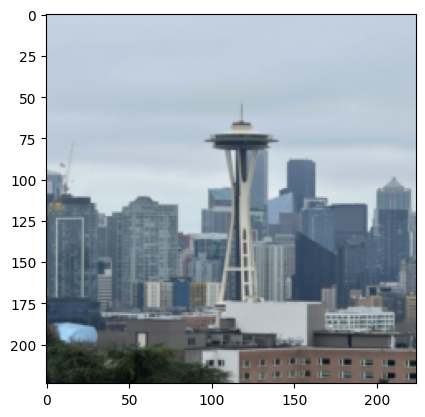

In [25]:
plt.imshow(img_needle_resized)

# TEST IMAGE TWO
INTERNATIONAL DISTRICT

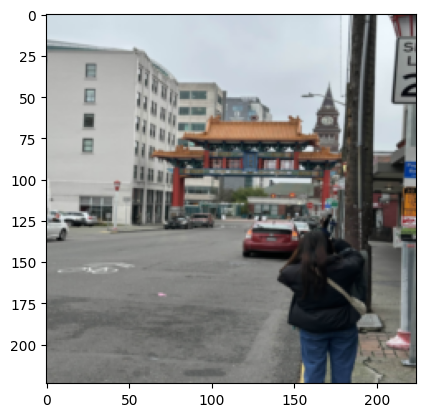

In [26]:
plt.imshow(img_chinatown_resized)

# TEST IMAGE THREE
SUZZALO LIBRARY (UW)

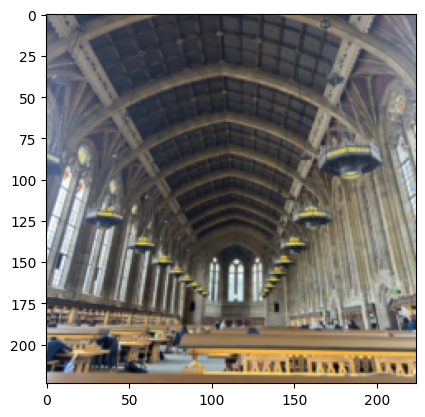

In [27]:
plt.imshow(img_library_resized)

# TEST IMAGE FOUR
Drumheller Fountain (UW)

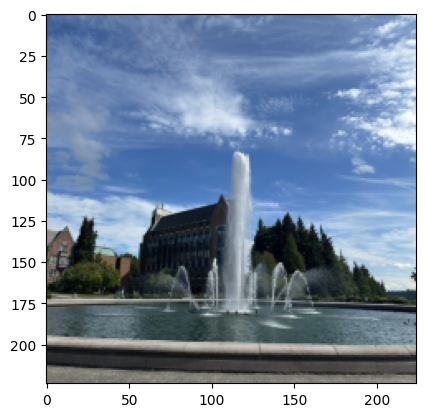

In [29]:
plt.imshow(img_fountain_resized)